# Anchoring illustration with toy classification

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import  make_circles


## Create dataset

In [4]:
from sklearn.model_selection import train_test_split
np.random.seed(1234)
noise = 0.1
centers = 1*np.array([(-2.5, 2.5),(-2.5, 0.5), (-0.5, 2.5)])
X,y =  make_circles(n_samples=250,noise=0.11, factor=.4, random_state=1,)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.01)


In [5]:
domain = 1.25
domax = X_train[:,0].max()
x_lin = np.linspace(-domain, domain, 100)
y_lin = np.linspace(-domain, domain, 100)

xx, yy = np.meshgrid(x_lin, y_lin)

x_grid = np.column_stack([xx.flatten(), yy.flatten()])
x_grid.shape

(10000, 2)

In [6]:
xx.max(), X_train.max()

(1.25, 1.211302288550573)

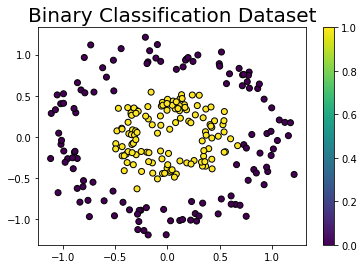

In [21]:
cm = plt.cm.RdBu

# Plot the training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, 
           edgecolors='k')
plt.colorbar()
ax = plt.gca()
plt.title('Binary Classification Dataset',fontsize=20)

plt.show()

## Creating reparameterized training data $X \mapsto (C,X-C)$

In [54]:
def create_paired_training(X_train,y_train,al=0.):
    np.random.seed(1234)
    X = []
    y = []
    for i in range(100):
        ids1 = np.random.choice(X_train.shape[0],2,replace=False)
        ids2 = np.random.choice(X_train.shape[0],2,replace=False)
        diff = X_train[ids2,:]-X_train[ids1,:]
        X.append(np.concatenate([X_train[ids2,:],X_train[ids1,:]+al*np.random.rand(2)],axis=1))
        y.append(y_train[ids2])
    return np.array(X),np.array(y)


In [56]:

def get_prediction(clf,x_grid,anchor_z):
    dpreds = []
    anchor = np.tile(anchor_z,[x_grid.shape[0],1])
    diff = x_grid - anchor
    inp = np.concatenate([x_grid,anchor],axis=1)
    dpreds.append(clf.predict_proba(inp))
    return np.array(dpreds)
    

## Fit MLP Classifier

In [57]:
from sklearn.neural_network import MLPClassifier

plt.figure(figsize=(20,15))
all_means = []

X_train2,y_train2 = create_paired_training(X_train,y_train)
X_train2 = X_train2.reshape(-1,4)
y_train2 = y_train2.reshape(-1,)

clf = MLPClassifier(hidden_layer_sizes=[256],max_iter=1000,batch_size=64,activation='relu')
clf.fit(X_train2, y_train2)
k = 20
ids = np.random.choice(X_train.shape[0],k,replace=False)
anchors = X_train[ids,:]


mus = []
for i in range(anchors.shape[0]):
    anchor_z = anchors[i,:]
    dp = get_prediction(clf,x_grid,anchor_z)
    mu = dp[:,:,1]
    mus.append(dp[0,:,:])
    
M = np.array(mus)
mumu = np.mean(M,0)
mustd = np.std(M,0)

<Figure size 1440x1080 with 0 Axes>

## Plot uncertainty on the training domain

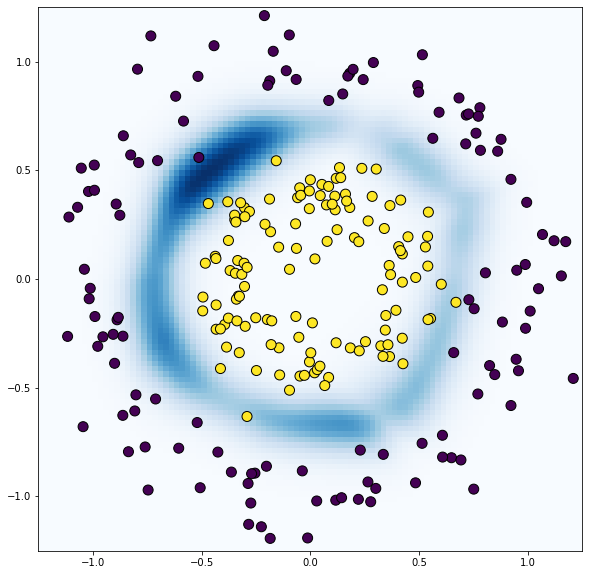

In [58]:
plt.figure(figsize=(10,10))
plt.imshow(mustd.sum(1).reshape(100,100),origin='lower',cmap='Blues',extent=(xx.min(),xx.max(),yy.min(),yy.max()))

plt.scatter(X_train[:,0],X_train[:,1],c=y_train,edgecolor='k',s=100)

plt.show()

## Draw decision boundaries

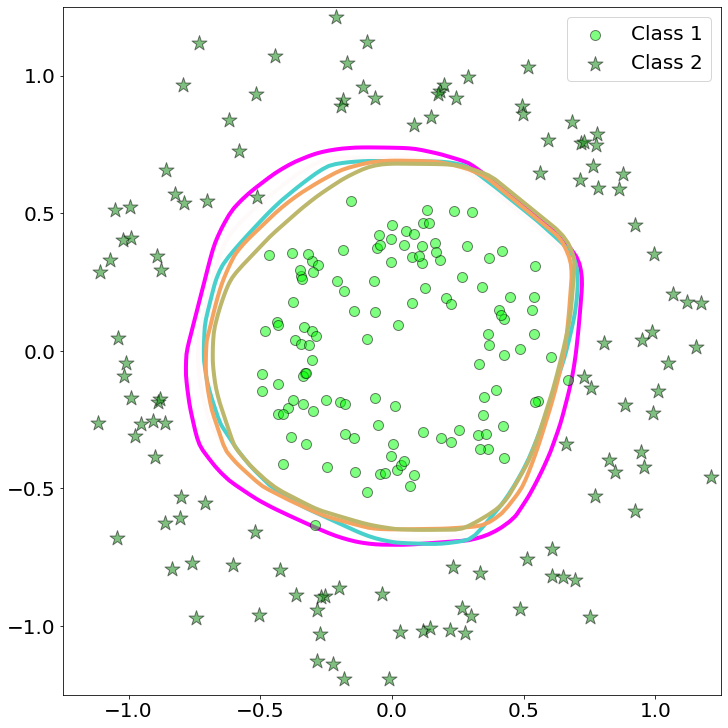

In [59]:
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors


colors=mcolors.CSS4_COLORS
n_anchors = 5
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())

clist = ['snow', 'fuchsia', 'mediumturquoise', 'sandybrown', 'darkkhaki']
fig, ax = plt.subplots(constrained_layout=True,figsize=(10,10))

for i in range(n_anchors):
    f1 = M[i,:,0].reshape(100,100)
    cs = ax.contour(xx,yy,f1[::], levels=1, linestyles='-',alpha=1,linewidths=4,colors=clist[i])


plt.scatter(X_train[y_train==1,0],X_train[y_train==1,1],marker='o',c='lime',edgecolor='k',s=100,zorder=100,alpha=0.5,label='Class 1')
plt.scatter(X_train[y_train==0,0],X_train[y_train==0,1],marker='*',c='green',edgecolor='k',s=250,zorder=101,alpha=0.5,label='Class 2')

plt.legend(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()